<a href="https://colab.research.google.com/github/rachelhakes/LDL/blob/master/Hakes_Basketball_Shot_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basketball Shot Analysis

## Step 1: Study Your Data
Sports statistics are all the rave. Front offices continue to become more dependent on analytics, fans immerse themselves in the action through fantasy teams, and stats are posted on countless social media outlets.

With the NBA, points are a central focus. Great scorers can come in a variety of boxes, though. Klay Thompson is famous for his quick release off of the catch and shoot. Shaq, on the other hand, dominated the paint during his years with the Lakers. Kobe Bryant got the job done at all three levels as one of the NBA's most prolific scorers.

The dataset, which is available [here](https://www.kaggle.com/dansbecker/nba-shot-logs), will guide us throughout our NBA scoring analysis.  

We will use this dataset to analyze different types of scorers. Our main question is

**How do the most prolific scorers compare to the most efficient ones? In other words, are those with the highest points per game also achieving the highest points per shot?**

As a follow up, we will explore the question:

**How does shot location have an affect on points per shot? And how does shot clock time affect the most prolific and efficient scorers?**  

Through our analysis, people will be able to learn about **diversity in scoring**, especially appreciating what *role players* bring to a team offensively.   

In future analysis, we would love to add **player position** to the dataset to explore the nuanced scoring differences between guards, forwards, and post players.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

### Load the Data

In [ ]:
# Mount to my own drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
shot_log_df = pd.read_csv('/content/gdrive/MyDrive/Final-exam-data6505/Rachel/ Rachel Copy of shot_logs.csv')

### Take the first look at the data

- Data size
- missingness
- features (data dictionary?)
- other findings...

In [ ]:
shot_log_df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [ ]:
shot_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

**Creating a copy of the dataframe**

In [ ]:
# Create the copy
shot_log_df_copy = shot_log_df.copy()
# Note this only works until you start changing one of the dataframe
assert shot_log_df.equals(shot_log_df_copy)

**Rename columns**

In [ ]:
#### We assume that the column 'W' counts win and losses. Therefore, the column is being renamed to something that makes sense
shot_log_df['W'].value_counts()

W    64595
L    63474
Name: W, dtype: int64

In [ ]:
# inplace=True to affect the dataframe immediately and rename the column
shot_log_df.rename(columns = {'W': 'WIN_OR_LOSE'},
          inplace=True)

# Verify that we have changed the columnname of 'W' and that the rest of the column names are good to go
shot_log_df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'WIN_OR_LOSE', 'FINAL_MARGIN',
       'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST',
       'FGM', 'PTS', 'player_name', 'player_id'],
      dtype='object')

**Check shape and size of data**

In [ ]:
shot_log_df.shape

(128069, 21)

In [ ]:
shot_log_df.size

2689449

In [ ]:
assert shot_log_df.size == len(shot_log_df.index) * len(shot_log_df.columns)

### Determining how much data is missing

In [ ]:
# ratio of missing values in each column
shot_log_df.isna().mean().round(4)*100

#### Alternative way of calculating the ratio
# (shot_log_df.isna().sum() / shot_log_df.shape[0]).round(4) * 100

GAME_ID                       0.00
MATCHUP                       0.00
LOCATION                      0.00
WIN_OR_LOSE                   0.00
FINAL_MARGIN                  0.00
SHOT_NUMBER                   0.00
PERIOD                        0.00
GAME_CLOCK                    0.00
SHOT_CLOCK                    4.35
DRIBBLES                      0.00
TOUCH_TIME                    0.00
SHOT_DIST                     0.00
PTS_TYPE                      0.00
SHOT_RESULT                   0.00
CLOSEST_DEFENDER              0.00
CLOSEST_DEFENDER_PLAYER_ID    0.00
CLOSE_DEF_DIST                0.00
FGM                           0.00
PTS                           0.00
player_name                   0.00
player_id                     0.00
dtype: float64

Only the **SHOT_CLOCK** column has missing values.

In [ ]:
# First we have to create another column that splits the ':'.
shot_log_df["GAME_CLOCK_v2"] = shot_log_df["GAME_CLOCK"].str.split(":", expand=False)
# Check if we done it correctly
shot_log_df.head()

,GAME_ID,MATCHUP,LOCATION,WIN_OR_LOSE,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,GAME_CLOCK_v2
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,"[1, 09]"
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,"[0, 14]"
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,"[0, 00]"
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,"[11, 47]"
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,"[10, 34]"


In [ ]:
# Create a column that transform the GameClock into seconds. This can be done by using the new column that we created above.
shot_log_df["GAMECLOCK_SECONDS"] = shot_log_df["GAME_CLOCK_v2"].apply(lambda x : int(x[0]) * 60 + int(x[1]))
shot_log_df.head()

,GAME_ID,MATCHUP,LOCATION,WIN_OR_LOSE,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,GAME_CLOCK_v2,GAMECLOCK_SECONDS
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,"[1, 09]",69
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,"[0, 14]",14
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,"[0, 00]",0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,"[11, 47]",707
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,"[10, 34]",634


In [ ]:
# Create the copy
shot_log_df_copy1 = shot_log_df.copy()
# Note this only works until you start changing one of the dataframe
assert shot_log_df.equals(shot_log_df_copy1)

In [ ]:
# index list of the NaN values from only the SHOT_CLOCK column and game clock
rows_with_nan = set(shot_log_df[shot_log_df['SHOT_CLOCK'].isna()].index)
rows_over_seconds = set(shot_log_df[shot_log_df['GAMECLOCK_SECONDS']>24].index)
rows_to_drop = list(rows_with_nan & rows_over_seconds)
print(rows_to_drop)

# testing that the rows are above 24 seconds and nan in shot clock
tester = [81922, 81923, 81924, 57367, 57368, 57369, 57370, 49179, 49180, 49181, 49182, 49183, 49184, 49185, 49186, 49187, 57371, 57372, 118871, 118872, 118873, 32841, 32842]
shot_log_df.iloc[tester, :]


## dropping the columns with that index
shot_log_df.drop(shot_log_df.index[rows_to_drop], inplace=True)
shot_log_df.head()


[81922, 81923, 81924, 57367, 57368, 57369, 57370, 49179, 49180, 49181, 49182, 49183, 49184, 49185, 49186, 49187, 57371, 57372, 118871, 118872, 118873, 32841, 32842, 32843, 32844, 32845, 114765, 114766, 114767, 114768, 114769, 114770, 114771, 114773, 24677, 24678, 118882, 82067, 82068, 82069, 82070, 24724, 24725, 24726, 57572, 57573, 57574, 57575, 57576, 57577, 57578, 57580, 65811, 65812, 65813, 65814, 65815, 65816, 65817, 65818, 49500, 49501, 49502, 49503, 49505, 49506, 49507, 49508, 49509, 49510, 49511, 49512, 115056, 115057, 115058, 115059, 115060, 115061, 115062, 82295, 82296, 82297, 82298, 82299, 82300, 82301, 82302, 82303, 82304, 82305, 82307, 82308, 82309, 82310, 65926, 65927, 16796, 16797, 57759, 57760, 57761, 57762, 57763, 90527, 57765, 57766, 57767, 57768, 57769, 57770, 57771, 57772, 57773, 49585, 49586, 49587, 49588, 41402, 82395, 82396, 82397, 82398, 98789, 33272, 33273, 33274, 33275, 33276, 33277, 8704, 8705, 8706, 8707, 8708, 8709, 25111, 25112, 25113, 25114, 25115, 25116,

,GAME_ID,MATCHUP,LOCATION,WIN_OR_LOSE,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,GAME_CLOCK_v2,GAMECLOCK_SECONDS
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,"[1, 09]",69
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,"[0, 14]",14
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,"[0, 00]",0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,"[11, 47]",707
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,"[10, 34]",634


In [ ]:
#checking that they were dropped
dropped_nan = set(shot_log_df[shot_log_df['SHOT_CLOCK'].isna()].index)
dropped_seconds = set(shot_log_df[shot_log_df['GAMECLOCK_SECONDS']>24].index)

assert len(dropped_nan & dropped_seconds) == 0


In [ ]:
# Create the copy
shot_log_df_copy2 = shot_log_df.copy()
# Note this only works until you start changing one of the dataframe
assert shot_log_df.equals(shot_log_df_copy2)

In [ ]:
#setting nan values equal to game clock
def filling_na(row):
  if pd.isnull(row['SHOT_CLOCK']):
    return row["GAMECLOCK_SECONDS"]
  else:
    return row["SHOT_CLOCK"]
#create a new column for imputed shot clock values
shot_log_df["SHOT_CLOCK_IMPUTED"] = shot_log_df.apply(lambda x: filling_na(x), axis=1)
shot_log_df.sample(20)

,GAME_ID,MATCHUP,LOCATION,WIN_OR_LOSE,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,GAME_CLOCK_v2,GAMECLOCK_SECONDS,SHOT_CLOCK_IMPUTED
5055,21400464,"DEC 29, 2014 - UTA @ LAC",A,L,-4,7,1,2:21,13.1,6,4.5,11.3,2,missed,"Barnes, Matt",2440,4.9,0,0,gordon hayward,202330,"[2, 21]",141,13.1
32678,21400093,"NOV 09, 2014 - TOR vs. PHI",H,W,32,1,1,7:48,9.9,2,3.5,18.9,2,made,"McDaniels, KJ",203909,4.3,1,2,terrence ross,203082,"[7, 48]",468,9.9
119476,21400025,"OCT 31, 2014 - POR @ SAC",A,L,-9,8,4,4:29,4.1,0,0.8,25.4,3,made,"McLemore, Ben",203463,5.0,1,3,damian lillard,203081,"[4, 29]",269,4.1
127262,21400421,"DEC 23, 2014 - BKN vs. DEN",H,W,6,7,4,9:46,4.5,0,0.7,19.1,2,missed,"Afflalo, Arron",201167,5.2,0,0,bojan bogdanovic,202711,"[9, 46]",586,4.5
70693,21400425,"DEC 23, 2014 - PHX vs. DAL",H,W,9,9,3,4:28,16.3,0,1.4,15.4,2,missed,"Villanueva, Charlie",101111,4.6,0,0,markieff morris,202693,"[4, 28]",268,16.3
82719,21400118,"NOV 13, 2014 - MEM vs. SAC",H,W,1,12,4,8:57,15.0,9,7.2,4.7,2,missed,"Evans, Reggie",2501,1.6,0,0,mike conley,201144,"[8, 57]",537,15.0
96218,21400462,"DEC 29, 2014 - MIA vs. ORL",H,L,-1,12,4,1:11,8.0,9,10.9,10.2,2,missed,"Oladipo, Victor",203506,2.4,0,0,dwayne wade,2548,"[1, 11]",71,8.0
96946,21400143,"NOV 16, 2014 - MIA vs. MIL",H,L,-7,2,1,3:37,6.2,0,1.1,25.0,3,made,"Middleton, Khris",203114,10.2,1,3,james ennis,203516,"[3, 37]",217,6.2
52972,21400563,"JAN 12, 2015 - BOS vs. NOP",H,W,8,1,1,10:40,17.9,12,6.7,19.7,2,missed,"Holiday, Jrue",201950,3.8,0,0,avery bradley,202340,"[10, 40]",640,17.9
126190,21400060,"NOV 05, 2014 - BKN vs. MIN",H,L,-7,8,3,10:05,18.6,4,5.0,4.8,2,made,"Pekovic, Nikola",201593,2.8,1,2,deron williams,101114,"[10, 05]",605,18.6


### Check data types

In [ ]:
shot_log_df.dtypes

GAME_ID                         int64
MATCHUP                        object
LOCATION                       object
WIN_OR_LOSE                    object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
DRIBBLES                        int64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
GAME_CLOCK_v2                  object
GAMECLOCK_SECONDS               int64
SHOT_CLOCK_IMPUTED            float64
dtype: object

In [ ]:
# Changing types of Game_ID, Player_id and CLOSEST_DEFENDER_PLAYER_ID
shot_log_df['GAME_ID'] = shot_log_df['GAME_ID'].astype('category')
shot_log_df['CLOSEST_DEFENDER_PLAYER_ID'] = shot_log_df['CLOSEST_DEFENDER_PLAYER_ID'].astype('category')
shot_log_df['player_id'] = shot_log_df['player_id'].astype('category')
shot_log_df['PTS_TYPE'] = shot_log_df['PTS_TYPE'].astype('category')

In [ ]:
# Assert that the column type has been changed to category
assert shot_log_df['GAME_ID'].dtypes == 'category'
assert shot_log_df['CLOSEST_DEFENDER_PLAYER_ID'].dtypes == 'category'
assert shot_log_df['player_id'].dtypes == 'category'
assert shot_log_df['PTS_TYPE'].dtypes == 'category'

In [ ]:
# Verify that we have the columns in correct types
shot_log_df.dtypes

GAME_ID                       category
MATCHUP                         object
LOCATION                        object
WIN_OR_LOSE                     object
FINAL_MARGIN                     int64
SHOT_NUMBER                      int64
PERIOD                           int64
GAME_CLOCK                      object
SHOT_CLOCK                     float64
DRIBBLES                         int64
TOUCH_TIME                     float64
SHOT_DIST                      float64
PTS_TYPE                      category
SHOT_RESULT                     object
CLOSEST_DEFENDER                object
CLOSEST_DEFENDER_PLAYER_ID    category
CLOSE_DEF_DIST                 float64
FGM                              int64
PTS                              int64
player_name                     object
player_id                     category
GAME_CLOCK_v2                   object
GAMECLOCK_SECONDS                int64
SHOT_CLOCK_IMPUTED             float64
dtype: object

In [ ]:
# Counting the types
shot_log_df.dtypes.value_counts()

object      8
int64       7
float64     5
category    1
category    1
category    1
category    1
dtype: int64

Since we now have `SHOT_CLOCK_IMPUTED` we can drop the original column called `SHOT_CLOCK`

In [ ]:
# run this once
shot_log_df = shot_log_df.drop('SHOT_CLOCK', 1)

## Step 2: Descriptive Stats

### Overall Descriptive Stats

In [ ]:
shot_log_df.describe().round(2)

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,FGM,PTS,GAMECLOCK_SECONDS,SHOT_CLOCK_IMPUTED
count,126056.00,126056.00,126056.00,126056.00,126056.00,126056.00,126056.00,126056.00,126056.00,126056.00,126056.00
mean,0.21,6.53,2.48,2.03,2.77,13.57,4.12,0.45,1.00,351.01,12.22
std,13.27,4.72,1.14,3.48,3.01,8.89,2.76,0.50,1.13,207.73,5.90
min,-53.00,1.00,1.00,0.00,-100.50,0.00,0.00,0.00,0.00,0.00,0.00
25%,-8.00,3.00,1.00,0.00,0.90,4.70,2.30,0.00,0.00,172.00,7.90
50%,1.00,5.00,2.00,1.00,1.60,13.70,3.70,0.00,0.00,352.00,12.10
75%,9.00,9.00,3.00,2.00,3.70,22.50,5.30,1.00,2.00,531.00,16.50
max,53.00,38.00,7.00,32.00,24.90,47.20,53.20,1.00,3.00,720.00,24.00


### Insert Visual Depictions Below for Proper Dataset Understanding

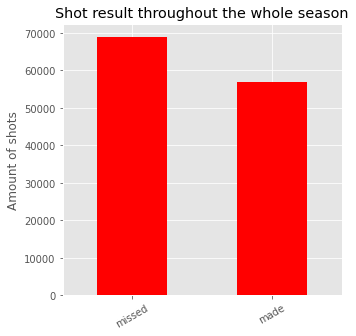

In [ ]:
# write your code below
plt.figure(figsize=(5,5)) # setting figsize
shot_log_df['SHOT_RESULT'].value_counts().plot(kind="bar", color = 'red') # setting plot to be a bar
plt.title('Shot result throughout the whole season') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Amount of shots") # y - axis label
plt.show()

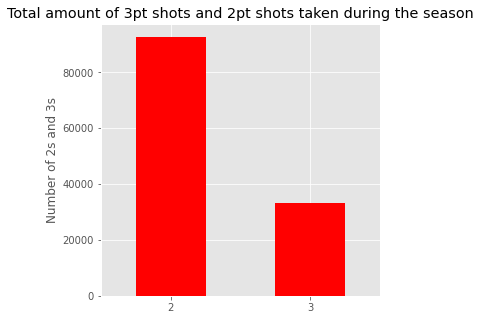

In [ ]:
# write your code below
plt.figure(figsize=(5,5)) # setting figsize
shot_log_df['PTS_TYPE'].value_counts().plot(kind="bar", color = 'red') # setting plot to be a bar
plt.title('Total amount of 3pt shots and 2pt shots taken during the season') # title
plt.xticks(rotation=0) # rotate xlabels
plt.ylabel("Number of 2s and 3s") # y - axis label
plt.show()

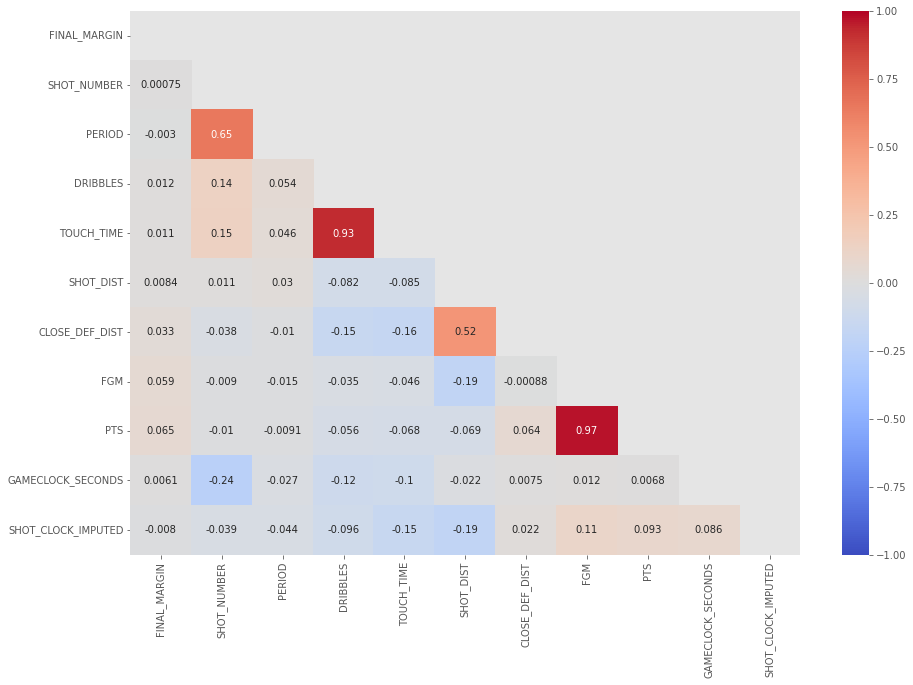

In [ ]:
#### get the categorical variables out

# create a mask for the upper triangle
corr = shot_log_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot again
plt.figure(figsize=(15,10))
sns.heatmap(corr,
            vmin=-1, vmax=1, # set the color bar range to [-1, 1]
            cmap='coolwarm', # set the color scheme to 'coolwarm'
            annot=True, # annotate the grid
            mask = mask) # mask the upper triangle

**Top four pairs which are highly correlated with each other**

| feature 1 | feature 2 | coeff. |
| --------- | --------- | ------ |
| PTS  | FGM| 0.97 |
| DRIBBLES  | TOUCH_TIME| 0.93 |
| SHOT_NUMBER  | PERIOD| 0.65 |
| SHOT_DIST  | CLOSE_DEF_DIST| 0.52 |

## Step 3: Feature Transformation/Creation

In [ ]:
#labeling shot distance
shot_log_df['Location'] = np.where(shot_log_df['SHOT_DIST']< 7, 'Short Jumper', np.where(shot_log_df['SHOT_DIST']> 23, "3-Point", "Mid-Range"))

#### alternative way: use `pd.cut` instead of `np.where`

#verifying locations are correct
shot_log_df[['Location', 'SHOT_DIST']].head(10)

,Location,SHOT_DIST
0,Mid-Range,7.7
1,3-Point,28.2
2,Mid-Range,10.1
3,Mid-Range,17.2
4,Short Jumper,3.7
5,Mid-Range,18.4
6,Mid-Range,20.7
7,Short Jumper,3.5
8,3-Point,24.6
9,Mid-Range,22.4


In [ ]:
## shot clock feature
#labeling shot distance
shot_log_df['SHOT_CLOCK_TIME'] = np.where(shot_log_df['SHOT_CLOCK_IMPUTED']< 7, '0-6 seconds', np.where(shot_log_df['SHOT_CLOCK_IMPUTED']> 15, "16-24 seconds", "7-15 seconds"))

#### alternative way: use `pd.cut` instead of `np.where`

#verifying locations are correct
shot_log_df[['SHOT_CLOCK_TIME', 'SHOT_CLOCK_IMPUTED']].head(10)

,SHOT_CLOCK_TIME,SHOT_CLOCK_IMPUTED
0,7-15 seconds,10.8
1,0-6 seconds,3.4
2,0-6 seconds,0.0
3,7-15 seconds,10.3
4,7-15 seconds,10.9
5,7-15 seconds,9.1
6,7-15 seconds,14.5
7,0-6 seconds,3.4
8,7-15 seconds,12.4
9,16-24 seconds,17.4


## Step 4: Answer Your Analytical Question

In [ ]:
shot_log_df.groupby(['player_name']).agg({'PTS': ['sum'], 'SHOT_CLOCK_IMPUTED': ['mean'], 'CLOSE_DEF_DIST': ['mean'], 'SHOT_DIST': ['mean']}).sort_values(by=[('PTS', 'sum')], ascending=False).iloc[:10]

,PTS,SHOT_CLOCK_IMPUTED,CLOSE_DEF_DIST,SHOT_DIST
,sum,mean,mean,mean
player_name,,,,
stephen curry,1128,14.686943,4.512539,17.463523
james harden,1084,12.436111,3.763410,14.827299
klay thompson,1072,13.598760,4.173657,16.789463
lebron james,1041,11.578199,4.197134,14.018526
mnta ellis,999,12.240193,4.293720,14.396039
kyrie irving,998,12.807325,3.649151,14.226539
lamarcus aldridge,959,11.249807,4.061896,13.577563
damian lillard,958,12.982586,4.150782,16.384984


Intersting that the top scorers are all **point guards**, we'll investigate this more later.

In [ ]:
shot_log_df.groupby(['player_name']).agg({'PTS': ['mean'], 'SHOT_CLOCK_IMPUTED': ['mean'], 'CLOSE_DEF_DIST': ['mean'], 'SHOT_DIST': ['mean']}).sort_values(by=[('PTS', 'mean')], ascending=False).iloc[:10]

,PTS,SHOT_CLOCK_IMPUTED,CLOSE_DEF_DIST,SHOT_DIST
,mean,mean,mean,mean
player_name,,,,
deandre jordan,1.424936,17.128753,2.892621,3.417812
tyson chandler,1.359281,15.706287,3.245509,4.148802
kyle korver,1.342795,14.033624,4.998908,22.005895
luke babbitt,1.274510,12.176471,5.905229,19.601961
james johnson,1.260450,12.232476,3.490354,7.845338
rudy gobert,1.250936,14.700000,2.424345,3.551311
greg smith,1.234043,13.768085,2.691489,2.670213
ed davis,1.221122,13.677558,2.234323,4.440264


The average scorers here are dominated by **post players**.

<Figure size 1080x360 with 0 Axes>

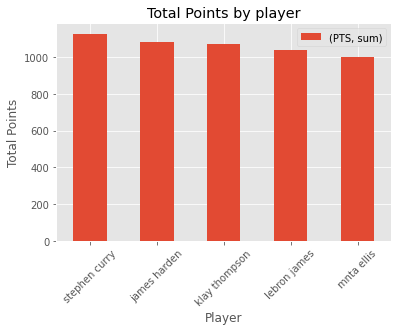

In [ ]:
# top five scorers
plt.figure(figsize=(15,5)) # setting figsize
shot_log_df.groupby('player_name').agg({'PTS': [sum]}).sort_values(by=[('PTS', 'sum')], ascending=False).iloc[:5].plot(kind='bar');
plt.title('Total Points by player') # title
plt.xticks(rotation=45) # rotate xlabels
plt.ylabel("Total Points") # y - axis label
plt.xlabel("Player")
plt.legend()


In [ ]:
# Create the copy
shot_log_df_copy3 = shot_log_df.copy()
# Note this only works until you start changing one of the dataframe
assert shot_log_df.equals(shot_log_df_copy3)

<Figure size 1080x360 with 0 Axes>

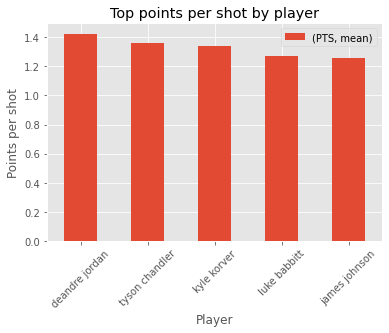

In [ ]:
## this is points per shot
plt.figure(figsize=(15,5)) # setting figsize
shot_log_df.groupby('player_name').agg({'PTS': ['mean']}).sort_values(by=[('PTS', 'mean')], ascending=False).iloc[:5].plot(kind='bar');
plt.title('Top points per shot by player') # title
plt.xticks(rotation=45) # rotate xlabels
plt.ylabel("Points per shot") # y - axis label
plt.xlabel("Player")
plt.legend()
#### none of these players are top ten scorers in the league!!

In [ ]:
# mid-range = least productive shot
shot_log_df.groupby('Location').agg({'PTS': ['mean']}).sort_values(by=[('PTS', 'mean')], ascending=False)

,PTS
,mean
Location,
Short Jumper,1.160599
3-Point,1.016222
Mid-Range,0.851216


Mid-Range shots are the least productive shot, aligns with moneyball ideology for basketball.

<Figure size 360x360 with 0 Axes>

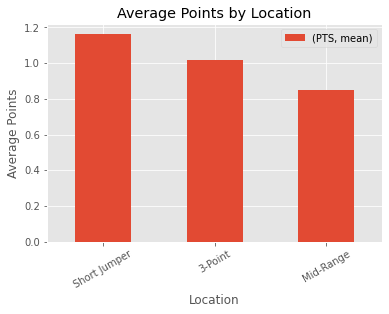

In [ ]:
## Average points by location
plt.figure(figsize=(5,5))
shot_log_df.groupby('Location').agg({'PTS': ['mean']}).sort_values(by=[('PTS', 'mean')], ascending=False).plot(kind='bar')
plt.title('Average Points by Location') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Average Points") # y - axis label
plt.xlabel("Location")
plt.legend()
plt.show()

<Figure size 360x360 with 0 Axes>

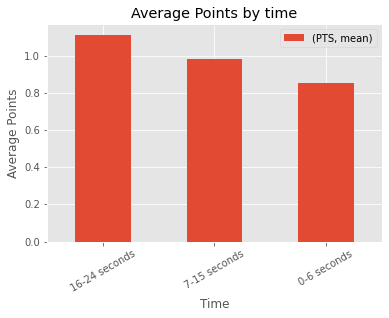

In [ ]:
##Averge points by shot clock time
plt.figure(figsize=(5,5))
shot_log_df.groupby('SHOT_CLOCK_TIME').agg({'PTS': ['mean']}).sort_values(by=[('PTS', 'mean')], ascending=False).plot(kind='bar')
plt.title('Average Points by time') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Average Points") # y - axis label
plt.xlabel("Time")
plt.legend()
plt.show()

In [ ]:
# slowest release times
shot_log_df.groupby('player_name').agg({'TOUCH_TIME': ['mean'], 'PTS': ['mean']}).sort_values(by=[('TOUCH_TIME', 'mean')], ascending=False).iloc[:10]

,TOUCH_TIME,PTS
,mean,mean
player_name,,
chris paul,5.997285,1.069005
dennis schroder,5.975670,0.926339
lebron james,5.724360,1.065507
james harden,5.706034,1.038314
john wall,5.630869,0.944836
jeff teague,5.549392,1.010638
elfrid payton,5.525630,0.836134
dj augustin,5.492586,0.929658


In [ ]:
# quickest average release matches same top 3 as points per shot
shot_log_df.groupby('player_name').agg({'TOUCH_TIME': ['mean'], 'SHOT_DIST': ['mean'] }).sort_values(by=[('TOUCH_TIME', 'mean')], ascending=True).iloc[:10]

,TOUCH_TIME,SHOT_DIST
,mean,mean
player_name,,
deandre jordan,0.779644,3.417812
tyson chandler,0.888024,4.148802
kyle korver,1.036026,22.005895
darrell arthur,1.065269,17.590120
dante cunningham,1.075102,14.208163
greg smith,1.076596,2.670213
rudy gobert,1.077528,3.551311
channing frye,1.086131,22.053041


<Figure size 1440x1440 with 0 Axes>

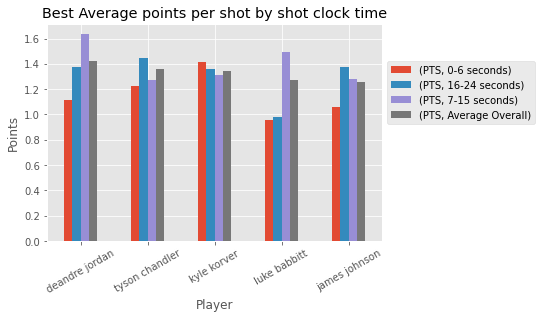

In [ ]:
# best points per shot by each shot clock time
plt.figure(figsize=(20,20))
shot_log_df.pivot_table(index = ['player_name'], columns = ['SHOT_CLOCK_TIME'],
                        values = ['PTS'], aggfunc= 'mean', margins=True, margins_name='Average Overall').sort_values(by=('PTS', 'Average Overall'),ascending=False).iloc[:5].plot(kind ='bar')
plt.title('Best Average points per shot by shot clock time') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Points") # y - axis label
plt.xlabel("Player")
plt.legend(loc = 'best',bbox_to_anchor=(1,.85))
plt.show()

<Figure size 1440x1440 with 0 Axes>

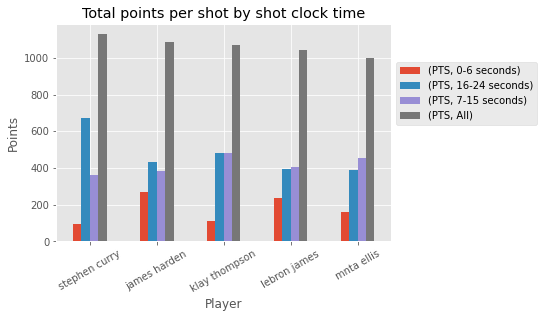

In [ ]:
# best total points per shot by each shot clock time
plt.figure(figsize=(20,20))
pivot = shot_log_df.pivot_table(index = ['player_name'], columns = ['SHOT_CLOCK_TIME'],
                        values = ['PTS'], aggfunc= 'sum', margins=True, margins_name='All').sort_values(by=('PTS', 'All'),ascending=False).iloc[:6]#.plot(kind ='bar')
pivot = pivot.drop('All')
pivot.plot(kind ='bar')
plt.title('Total points per shot by shot clock time') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Points") # y - axis label
plt.xlabel("Player")
plt.legend(loc = 'best',bbox_to_anchor=(1,.85))
plt.show()

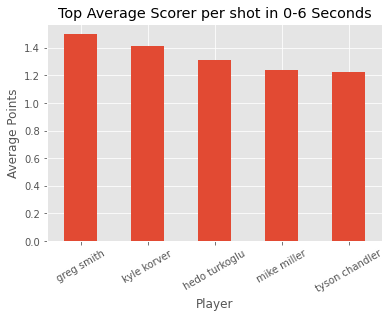

In [ ]:
##breaking it down into each group

shot_log_df[shot_log_df['SHOT_CLOCK_TIME'] == '0-6 seconds'].groupby('player_name')['PTS'].mean().sort_values(ascending = False).head(5).plot(kind = 'bar')
plt.title('Top Average Scorer per shot in 0-6 Seconds') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Average Points") # y - axis label
plt.xlabel("Player")
plt.show()

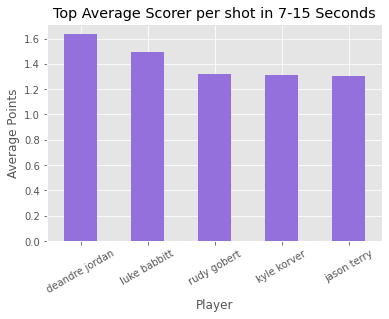

In [ ]:
shot_log_df[shot_log_df['SHOT_CLOCK_TIME'] == '7-15 seconds'].groupby('player_name')['PTS'].mean().sort_values(ascending = False).head(5).plot(kind = 'bar', color = 'mediumpurple')
plt.title('Top Average Scorer per shot in 7-15 Seconds') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Average Points") # y - axis label
plt.xlabel("Player")
plt.show()

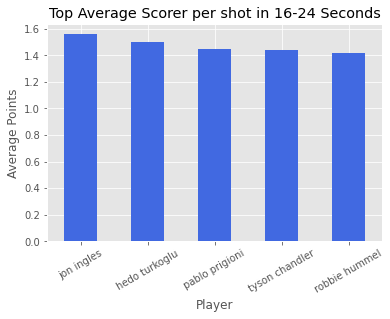

In [ ]:
shot_log_df[shot_log_df['SHOT_CLOCK_TIME'] == '16-24 seconds'].groupby('player_name')['PTS'].mean().sort_values(ascending = False).head(5).plot(kind = 'bar', color = 'royalblue')
plt.title('Top Average Scorer per shot in 16-24 Seconds') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Average Points") # y - axis label
plt.xlabel("Player")
plt.show()

Not the same players as the top average scorers now

<Figure size 1440x1440 with 0 Axes>

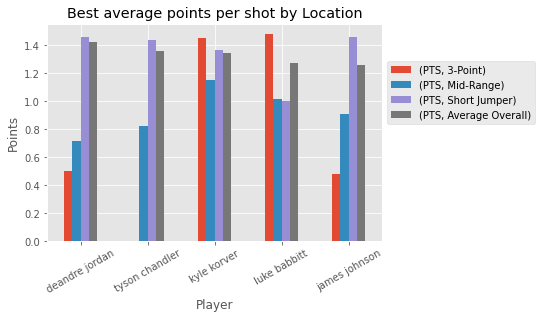

In [ ]:
# best average points per shot by each location
plt.figure(figsize=(20,20))
shot_log_df.pivot_table(index = ['player_name'], columns = ['Location'],
                        values = ['PTS'], aggfunc= 'mean', margins=True, margins_name='Average Overall').sort_values(by=('PTS', 'Average Overall'),ascending=False).iloc[:5].plot(kind ='bar')
plt.title('Best average points per shot by Location') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Points") # y - axis label
plt.xlabel("Player")
plt.legend(loc = 'best',bbox_to_anchor=(1,.85))
plt.show()

<Figure size 1440x1440 with 0 Axes>

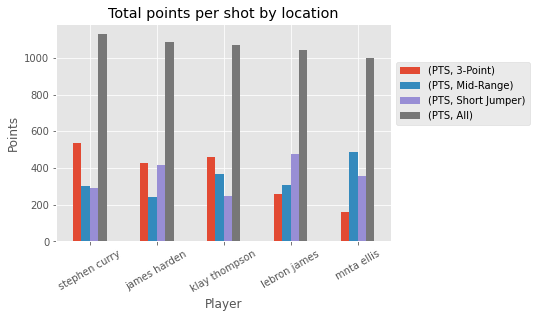

In [ ]:
# best points per shot by each location
plt.figure(figsize=(20,20))
pivot = shot_log_df.pivot_table(index = ['player_name'], columns = ['Location'],
                        values = ['PTS'], aggfunc= 'sum', margins=True, margins_name='All').sort_values(by=('PTS', 'All'),ascending=False).iloc[:6]#.plot(kind ='bar')
pivot = pivot.drop('All')
pivot.plot(kind ='bar')
plt.title('Total points per shot by location') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Points") # y - axis label
plt.xlabel("Player")
plt.legend(loc = 'best',bbox_to_anchor=(1,.85))
plt.show()

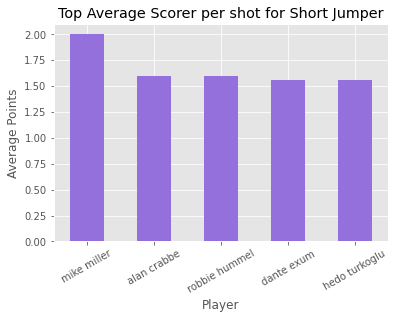

In [ ]:
shot_log_df[shot_log_df['Location'] == 'Short Jumper'].groupby('player_name')['PTS'].mean().sort_values(ascending = False).head(5).plot(kind = 'bar', color = 'mediumpurple')
plt.title('Top Average Scorer per shot for Short Jumper') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Average Points") # y - axis label
plt.xlabel("Player")
plt.show()

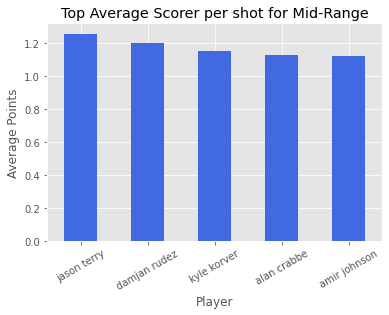

In [ ]:
shot_log_df[shot_log_df['Location'] == 'Mid-Range'].groupby('player_name')['PTS'].mean().sort_values(ascending = False).head(5).plot(kind = 'bar', color = 'royalblue')
plt.title('Top Average Scorer per shot for Mid-Range') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Average Points") # y - axis label
plt.xlabel("Player")
plt.show()

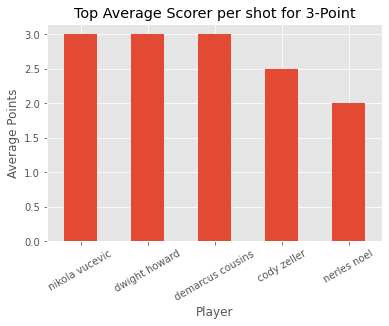

In [ ]:
shot_log_df[shot_log_df['Location'] == '3-Point'].groupby('player_name')['PTS'].mean().sort_values(ascending = False).head(5).plot(kind = 'bar')
plt.title('Top Average Scorer per shot for 3-Point') # title
plt.xticks(rotation=30) # rotate xlabels
plt.ylabel("Average Points") # y - axis label
plt.xlabel("Player")
plt.show()

### What can be learned from the analysis above?

In our analysis above, we were surprised to find that none of the top ten scorers in the league cracked the top ten of points per shot. In other words, the "best" scorers are certainly not the most efficient scorers. This is primarily due to the type of shots that are taken. On average, short jump shots (7 feet and in) produce 1.16 points per shot; mid-range shots (7-23 feet) produce 0.85 points per shot; and, 3-point shots (23 feet or further) produce 1.016 points per shot. The top scorers tended to take a variety of shots, with their average shot distance settling in the mid-range -- the least productive shot. On the other hand, those with the highest points per shot tended to be specialists. 8/10 of them took shots from 7 feet and in, on average. Meanwhile, the other two were three point speicialists. Additionally, the top ten scorers, led by Stephen Curry, featured much less productivity at the end of the shot clock, compared to those with the highest points per shot. This is likely because teams rely on their best scorers, like Curry, to force up shots as time expires. All in all, high scorers and efficiency are not synonomous, and shot location is a large indicator of point productivity that transcends shooting percentage.